
## CQF Final Project: Long/Short Trading Strategy Design & Backtest
### Alexys Pereira

### Introduction

### Methodology

### Data

### Implementation and Results

In [1]:
import os
import sys
sys.path.append(os.getcwd())
from pairs_trading import PairTradingBacktest,TradeAnalyzer
from cointegration import OLS, ADF, EngleGranger

import glob
import warnings 
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
import pandas_datareader.data as web
import itertools
import datetime as dt
from collections import Counter
from sklearn.linear_model import LinearRegression
from scipy import stats
pd.set_option("display.max_column",999)

In [2]:
def compute_risk_metrics(backtest_tbl,mkt_ticker = "SPY",historical_tbl=None):
   
    trade_analysis=[]
    for i, g in backtest_tbl.groupby("bounds_id"):
        historical_series = historical_tbl.query(f"bounds_id=={i}").set_index("day")['trade_daily_return'].dropna() if historical_tbl is not None else historical_tbl
        bounds_id = g.bounds_id.max()
        zscore=g.zscore.max()
        return_series = g['trade_daily_return'].copy()
        return_series.index=g.day
        return_series=return_series[return_series.notnull()]    
        analyzer = TradeAnalyzer(return_series, mkt_ticker,historical_returns=historical_series)
        analyzer.generate_analysis()
        analyzer.summary_table()   
        trade_analysis.append([bounds_id,zscore,analyzer])
    summary = pd.concat([ a.summary_table().assign(strategy_id=b, zscore=z) for b,z,a in trade_analysis])
    summary.head()
    summary['Strategy']="Z-Score = " + summary.zscore.astype(str)
    summary= summary.pivot(columns='Strategy',values=['Value (%)'],index='Metric')
    summary=summary.reindex(index=['Annual Return',
                                   'Annual Vol',
                                   'Cumulative Return',
                                   'Alpha (Annual)',
                                   'Sharpe','Beta',
                                   'Beta P-Value',
                                   'Alpha P-Value',
                                   'Max Drawdown',
                                   '1-Day VaR 99%',
                                   '10-Day VaR 99%',
                                   '1-Day ES 99%',
                                   '10-Day ES 99%',])
    
    trade_analysis=pd.DataFrame(trade_analysis,columns=['bounds_id','zscore','analyzer'])
    return summary,trade_analysis

In [3]:
tickers= [
            'CADUSD=X',
            'BZ=F',
            'RY.TO',
            'TD.TO',
            "JPYUSD=X",
            'GC=F',        

]


labels_ticker = ['CAD/USD', 
                 'Crude Oil Future',
                 'RBC',
                 'TD Bank',
                 'JPY/USD',
                 'Gold Futures',
                ]

pairs =[
        ['RY.TO','TD.TO'],
        ['CADUSD=X','BZ=F',],
        ["JPYUSD=X",'GC=F'],
       ]



In [4]:
labels_ticker = dict(zip(tickers,labels_ticker))


In [5]:

data = web.DataReader(tickers,'yahoo',start= '2008-01-01', end='2022-06-30')


In [6]:
data = data['Adj Close'].reset_index()

data.head()

Symbols,Date,CADUSD=X,BZ=F,RY.TO,TD.TO,JPYUSD=X,GC=F
0,2008-01-01,1.006847,NaN,NaN,NaN,0.008943,NaN
1,2008-01-02,1.005632,97.839996,27.910973,19.577114,0.009152,857.000000
2,2008-01-03,1.011327,97.599998,27.660757,19.467903,0.009132,866.400024
3,2008-01-04,1.001202,96.790001,27.466164,19.289728,0.009206,863.099976
4,2008-01-07,0.994530,94.389999,27.282701,18.870131,0.009155,859.599976


In [7]:
data.to_csv("data.csv",index=False)

In [8]:
data = data.fillna(method='ffill').dropna()
data.head()

Symbols,Date,CADUSD=X,BZ=F,RY.TO,TD.TO,JPYUSD=X,GC=F
1,2008-01-02,1.005632,97.839996,27.910973,19.577114,0.009152,857.000000
2,2008-01-03,1.011327,97.599998,27.660757,19.467903,0.009132,866.400024
3,2008-01-04,1.001202,96.790001,27.466164,19.289728,0.009206,863.099976
4,2008-01-07,0.994530,94.389999,27.282701,18.870131,0.009155,859.599976
5,2008-01-08,0.995223,95.540001,27.243769,18.717812,0.009289,878.000000


In [9]:
data[tickers]=data[tickers]/data.loc[0:1,tickers].values

train= data.loc[data.Date.between('2010-01-01','2016-12-31'),:].copy()
valid= data.loc[data.Date.between('2017-02-01','2019-02-01'),:].copy()
test= data.loc[data.Date.between('2019-03-01','2020-02-01'),:].copy()

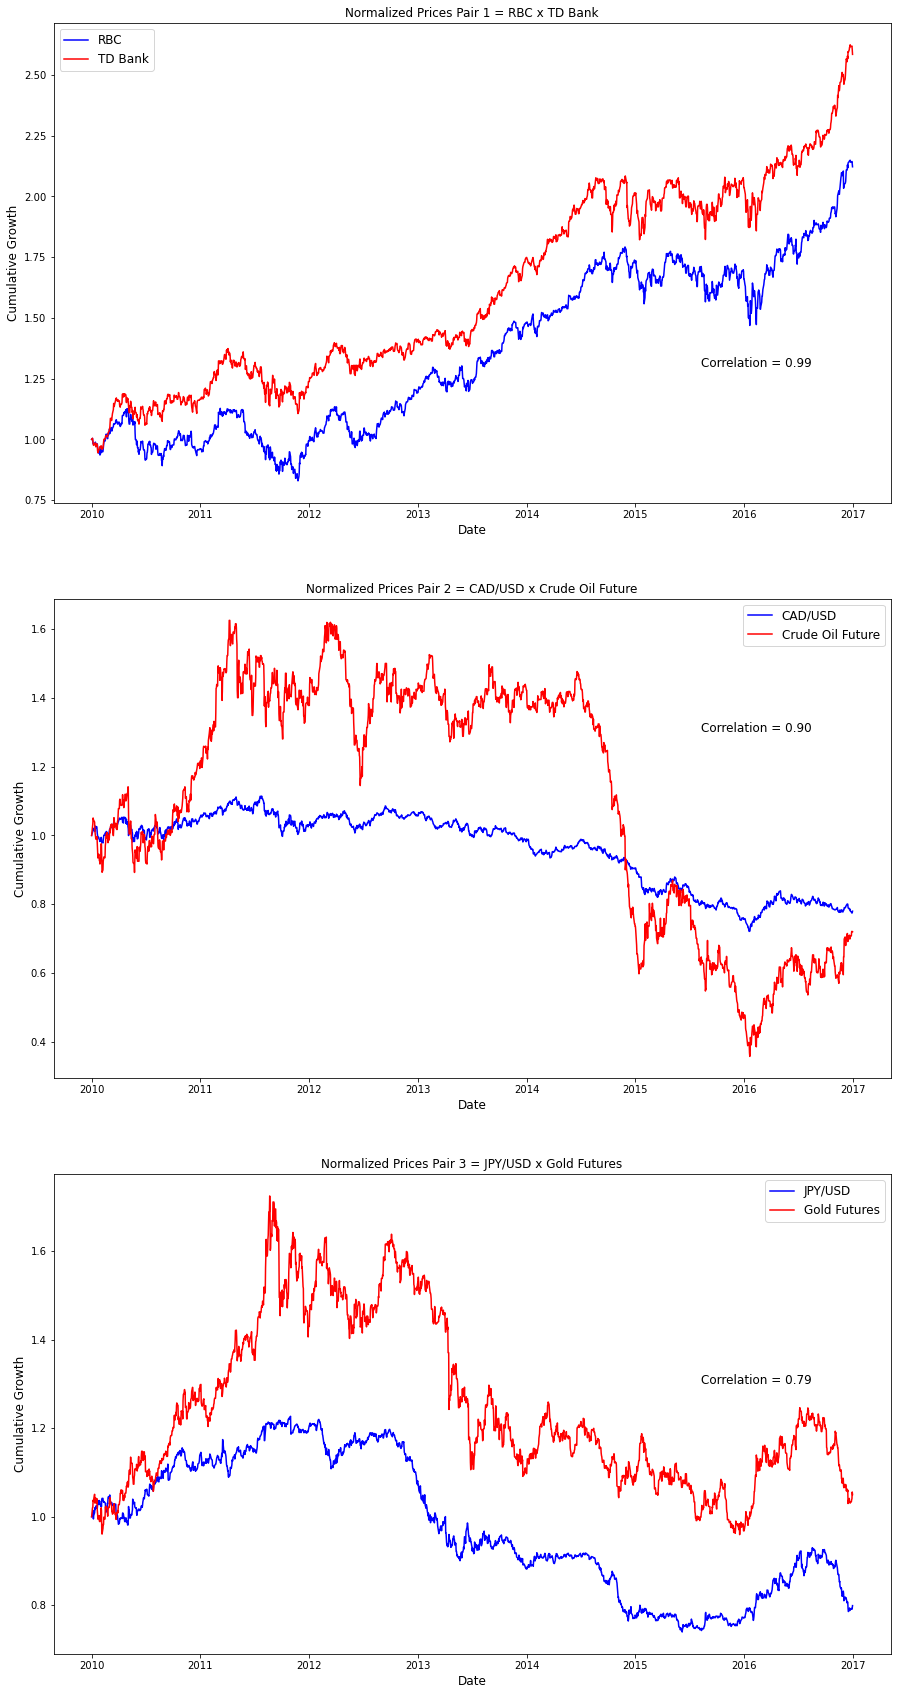

In [10]:
fig, ax = plt.subplots(nrows=len(pairs),ncols=1, figsize=(15,30),squeeze=True,)

for i, (T1,T2) in enumerate(pairs,1):
    corr = np.corrcoef(train[T1].values,train[T2].values,rowvar=False).min()
    ax[i-1].plot( train['Date'],train[T1]/train[T1].values[0],color='blue',label=labels_ticker[T1])
    ax[i-1].plot( train['Date'],train[T2]/train[T2].values[0],color='red',label=labels_ticker[T2])
    ax[i-1].set_title(f'Normalized Prices Pair {i} = {labels_ticker[T1]} x {labels_ticker[T2]}',fontsize=12)
    ax[i-1].set_xlabel(f'Date',fontsize=12)
    ax[i-1].set_ylabel(f'Cumulative Growth',fontsize=12)   
    ax[i-1].legend(loc='best',fontsize=12)
    ax[i-1].annotate(f"Correlation = {corr:.2f}",
                        xy=(dt.datetime(2016,8,10),1.3),
                        xytext=(dt.datetime(2015,8,10),1.3),fontsize=12)
    
plt.show()

### Pair 1: TD.TO x RY.TO

#### Engle Granger Fitting

In [11]:
eg = EngleGranger()

In [12]:
eg.fit(train['TD.TO'],train['RY.TO'])

In [13]:
eg.compare_ols

Variable  RY.TO                          Variable  TD.TO          \
Statistic             Beta P-Value     SE   T-Stat             Beta P-Value   
0          Constant  0.027   0.000  0.006    4.168  Constant  0.022   0.001   
1             TD.TO  0.972   0.000  0.004  262.293     RY.TO  0.999   0.000   

                           
Statistic     SE   T-Stat  
0          0.007    3.308  
1          0.004  262.293

In [14]:
eg.compare_adf

,Equation 1:,RY.TO = TD.TO + Constant,,Equation 2:,TD.TO = RY.TO + Constant,
Null Hypothesis,Series has unit root,,,Series has unit root,,
T-Statistic,-3.623505,,,-3.66111,,
P-Value (MacKinnon),0.005327,,,0.004695,,
Optimal Lag,0,,,0,,
Confidence Level,1%,5%,10%,1%,5%,10%
Mackinnon Critical Value,-3.433567,-2.862961,-2.567527,-3.433567,-2.862961,-2.567527
Reject/Not Reject H0,Reject,Reject,Reject,Reject,Reject,Reject
Stationary/Non Stationary,Stationary,Stationary,Stationary,Stationary,Stationary,Stationary


In [15]:
eg.ecm_results_table

dY                       
Statistic       Beta P-Value     SE  T-Stat
Variable                                   
dX             0.756   0.000  0.013  60.013
Residual(-1)  -0.008   0.002  0.003  -3.090

In [16]:
eg.ou_process_summary.style.set_caption("Table 4: OU Process")

,Value
OU Process Parameters,
$\mu_e$,0.012476
Half-Life (days),63.387043
$\sigma$,0.181998
$\theta$,2.755659


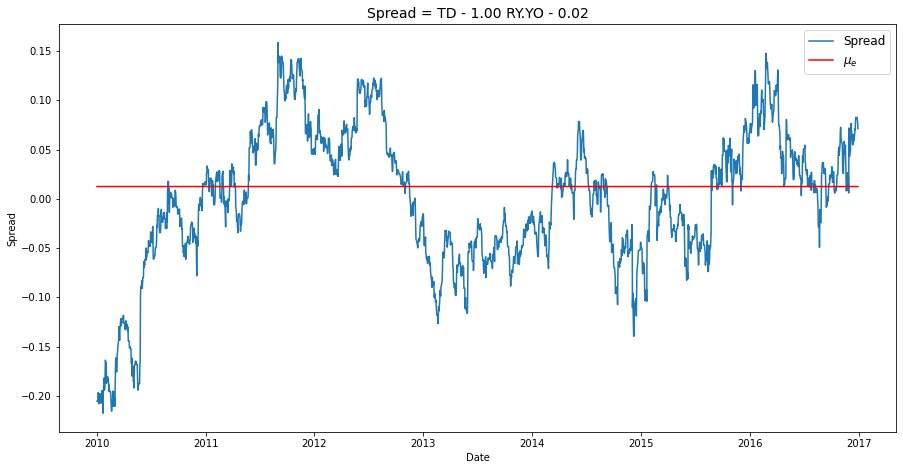

In [17]:
ou_parameters= eg.ou_process_params

coint_params= eg.cointegration_params

spread = eg.best_ols.residual.flatten()

fig= plt.figure(figsize=(15,7.5))
plt.plot(train.Date, spread,label='Spread')
plt.plot(train.Date, ou_parameters['mue']*np.ones(shape=train.Date.shape),color='red',label=r"$\mu_e$")
plt.title(f"Spread = TD - {coint_params[1]:.2f} RY.YO - {coint_params[0]:.2f}",fontsize=14)
plt.xlabel("Date")
plt.ylabel("Spread")
plt.legend(loc='best',fontsize=12)
plt.show()



#### Backtesting Pair Trading

In [18]:
z= [0.2,0.3,0.4,0.5,0.6,0.7]
z=np.array(z)

In [19]:
ptback_train = PairTradingBacktest(train.Date, 
                             train['RY.TO'],
                             train['TD.TO'],
                             coint_coeffs=coint_params.tolist(),
                             mue = ou_parameters['mue'],
                             sigma_eq=ou_parameters['sigma'],
                             zscores=z,
                             xy_label = ['RY.TO','TD.TO'],
                             tol=0.25)

In [20]:
ptback_valid = PairTradingBacktest(valid.Date, 
                             valid['RY.TO'],
                             valid['TD.TO'],
                             coint_coeffs=coint_params.tolist(),
                             mue = ou_parameters['mue'],
                             sigma_eq=ou_parameters['sigma'],
                             zscores=z,
                             xy_label = ['RY.TO','TD.TO'],
                             tol=0.25)

In [21]:
train_signals  = ptback_train.backtest()
valid_signals  = ptback_valid.backtest()


In [22]:
summary_train,trade_analysis_train = compute_risk_metrics(ptback_train.back_test_results,"XIU.TO")
summary_valid,trade_analysis_valid = compute_risk_metrics(ptback_valid.back_test_results,
                                                          "XIU.TO",
                                                          historical_tbl=ptback_train.back_test_results)

In [23]:
ptback_train.summary_tables()

,Strategy ID,Z-Score,# Trades,Annualized Return (%),Annualized Volatility (%),Cumulative Return (%),Avg # Days Open Position,Total Trading Days
0,1,0.2,17.0,6.481139,9.853542,48.213309,115.764706,1968
1,2,0.3,13.0,7.292828,9.870944,50.312328,140.230769,1823
2,3,0.4,7.0,9.453213,10.171794,53.415216,214.428571,1501
3,4,0.5,6.0,10.850216,10.008626,56.136094,227.833333,1367
4,5,0.6,5.0,11.716750,10.046207,55.082829,251.800000,1259
5,6,0.7,5.0,13.217583,9.857455,57.724142,231.800000,1159


In [24]:
summary_train

Value (%)                                            \
Strategy          Z-Score = 0.2 Z-Score = 0.3 Z-Score = 0.4 Z-Score = 0.5   
Metric                                                                      
Annual Return          6.481139      7.292828      9.453213     10.850216   
Annual Vol             9.853542      9.870944     10.171794     10.008626   
Cumulative Return     48.213309     50.312328     53.415216     56.136094   
Alpha (Annual)         6.738134      7.584519      9.597569     10.797017   
Sharpe                33.189280     40.913350     59.102414     73.061544   
Beta                   5.546452      6.593690      7.071625     10.418858   
Beta P-Value           0.248240      0.046738      0.057489      0.000125   
Alpha P-Value          8.652634      6.384128      3.947302      2.371787   
Max Drawdown          11.403234     10.066807      9.395346      7.732132   
1-Day VaR 99%          1.417153      1.416683      1.452740      1.423859   
10-Day VaR 99%         4.297868      4.275727      4.334837      4.209529   
1-Day ES 99%           1.627492      1.627393      1.669873      1.637509   
10-Day ES 99%          4.963020      4.942053      5.021472      4.885150   

                                               
Strategy          Z-Score = 0.6 Z-Score = 0.7  
Metric                                         
Annual Return         11.716750     13.217583  
Annual Vol            10.046207      9.857455  
Cumulative Return     55.082829     57.724142  
Alpha (Annual)        10.936025     12.628537  
Sharpe                80.248535     94.916828  
Beta                  10.369302      7.219679  
Beta P-Value           0.000533      0.255280  
Alpha P-Value          2.913620      1.399019  
Max Drawdown           7.732132      7.732132  
1-Day VaR 99%          1.426259      1.393377  
10-Day VaR 99%         4.195873      4.056188  
1-Day ES 99%           1.640711      1.603800  
10-Day ES 99%          4.874031      4.721603

In [25]:
ptback_valid.summary_tables()

,Strategy ID,Z-Score,# Trades,Annualized Return (%),Annualized Volatility (%),Cumulative Return (%),Avg # Days Open Position,Total Trading Days
0,1,0.2,6.0,1.621030,8.235455,3.406812,107.166667,643
1,2,0.3,5.0,1.313622,8.219709,2.665765,123.800000,619
2,3,0.4,5.0,2.997721,8.269945,5.923785,119.200000,596
3,4,0.5,4.0,3.065389,8.258247,5.843609,143.750000,575
4,5,0.6,3.0,1.840215,8.469132,3.138030,173.333333,520
5,6,0.7,2.0,0.078719,8.351491,0.130920,255.500000,511


In [26]:
summary_valid

Value (%)                                            \
Strategy          Z-Score = 0.2 Z-Score = 0.3 Z-Score = 0.4 Z-Score = 0.5   
Metric                                                                      
Annual Return          1.621030      1.313622      2.997721      3.065389   
Annual Vol             8.235455      8.219709      8.269945      8.258247   
Cumulative Return      3.406812      2.665765      5.923785      5.843609   
Alpha (Annual)         1.991925      1.770756      3.430150      3.378234   
Sharpe               -11.015625    -14.762633      5.279260      6.051971   
Beta                   3.667645      4.452493      4.519861      5.427305   
Beta P-Value          36.273841     27.192392     27.018473     19.158494   
Alpha P-Value         72.719768     75.982912     56.287478     57.475330   
Max Drawdown           8.665752      7.866278      7.193071      7.193071   
1-Day VaR 99%          1.199144      1.198043      1.198846      1.196875   
10-Day VaR 99%         3.739169      3.743942      3.701631      3.693641   
1-Day ES 99%           1.374943      1.373506      1.375381      1.373160   
10-Day ES 99%          4.295093      4.298804      4.259884      4.251104   

                                               
Strategy          Z-Score = 0.6 Z-Score = 0.7  
Metric                                         
Annual Return          1.840215      0.078719  
Annual Vol             8.469132      8.351491  
Cumulative Return      3.138030      0.130920  
Alpha (Annual)         2.335786      0.557546  
Sharpe                -8.161911    -29.308665  
Beta                   5.743950      5.038811  
Beta P-Value          18.502389     24.054063  
Alpha P-Value         71.956702     93.141948  
Max Drawdown           7.193071      7.193071  
1-Day VaR 99%          1.232455      1.222178  
10-Day VaR 99%         3.838127      3.853237  
1-Day ES 99%           1.413242      1.400454  
10-Day ES 99%          4.409826      4.416994

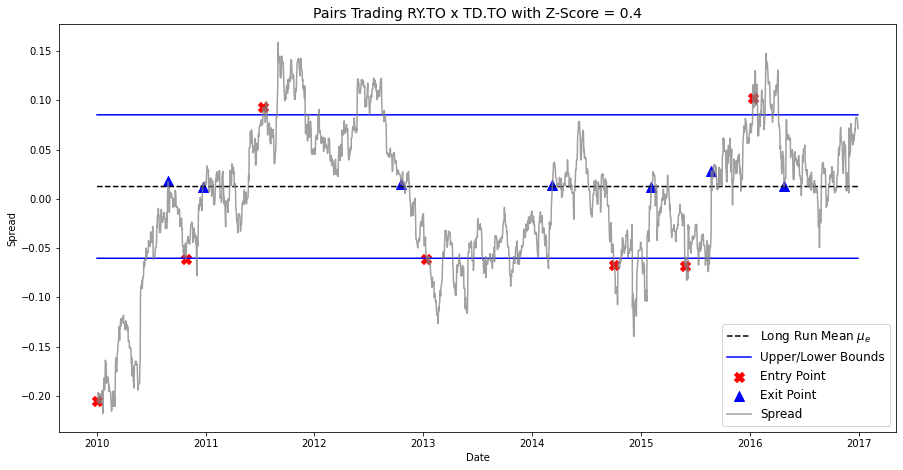

In [27]:
fig=ptback_train.plot_strategy(3)

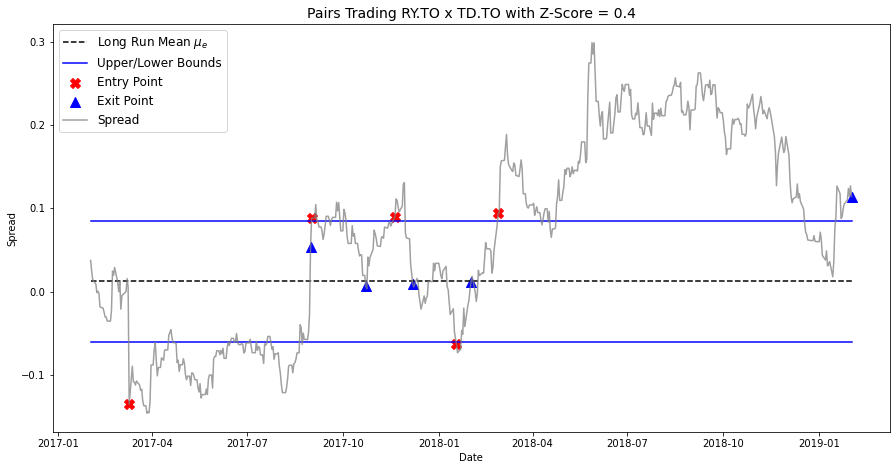

In [28]:
fig=ptback_valid.plot_strategy(3)

In [29]:
trade1 = trade_analysis_train.query("bounds_id==3")['analyzer'].values[0]


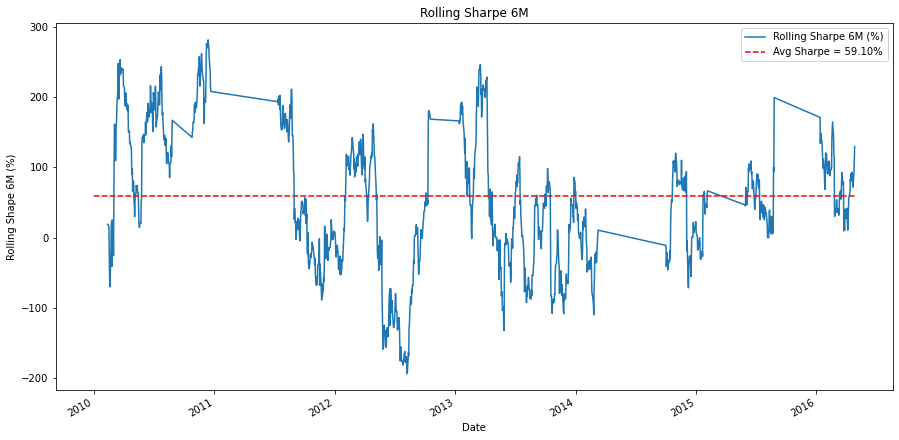

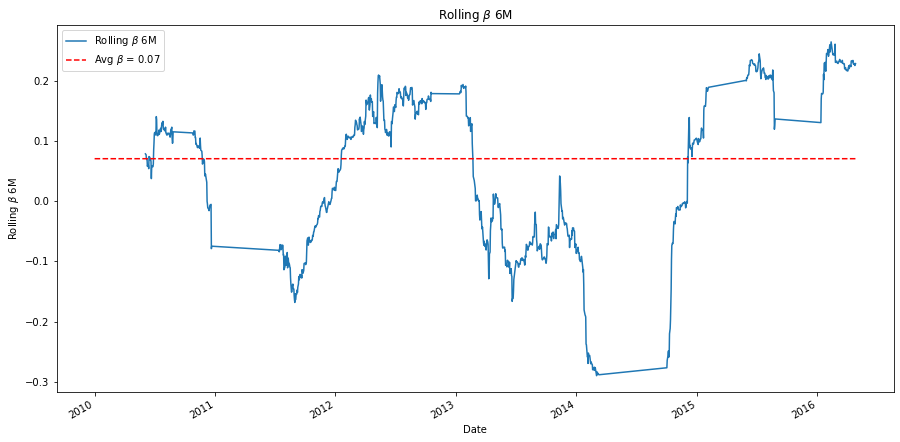

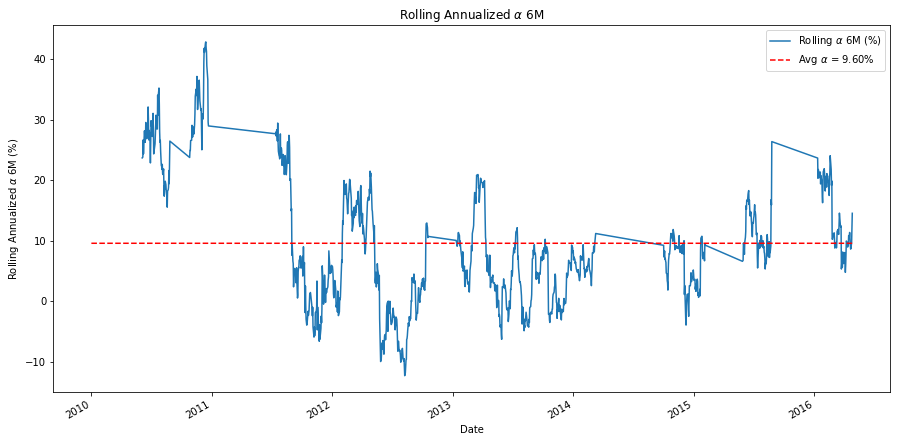

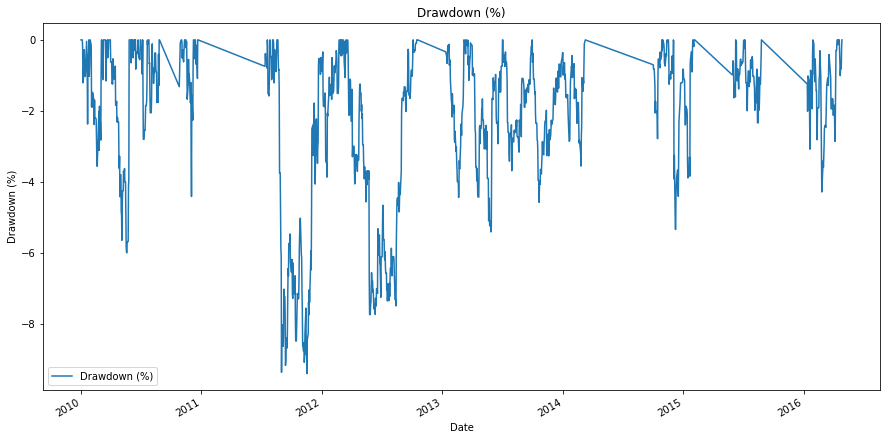

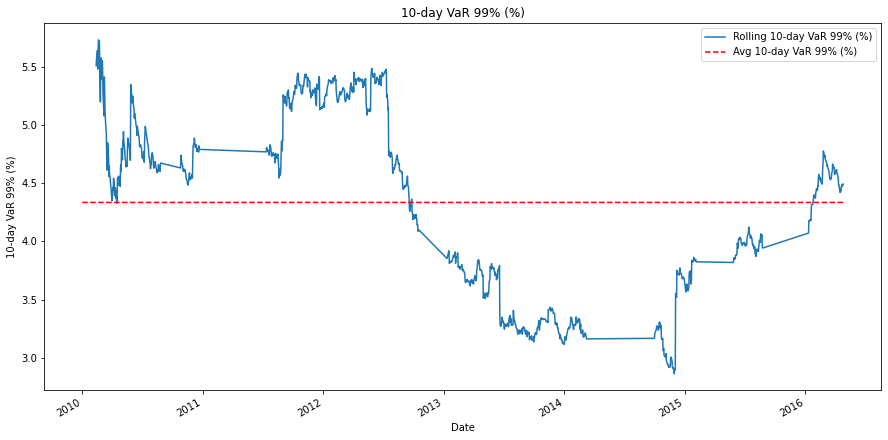

In [30]:
trade1plots=trade1.plots()

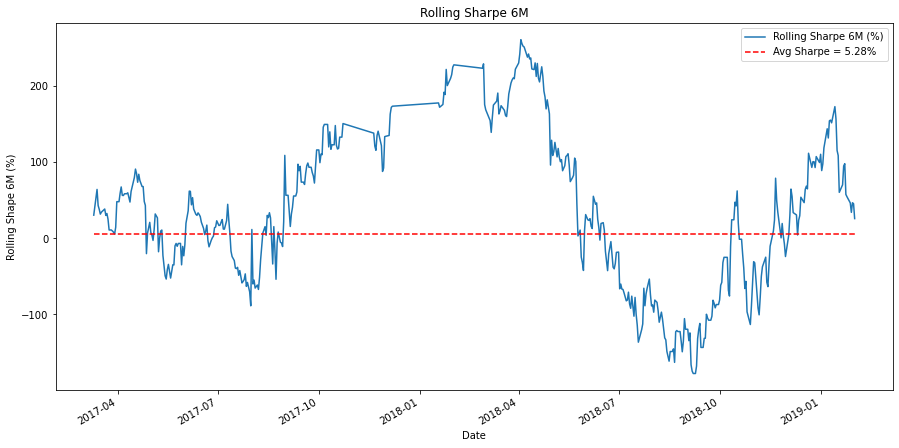

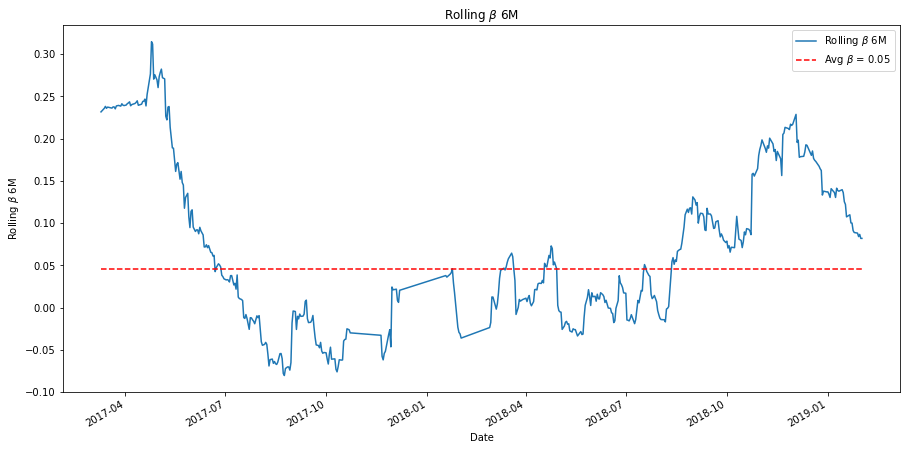

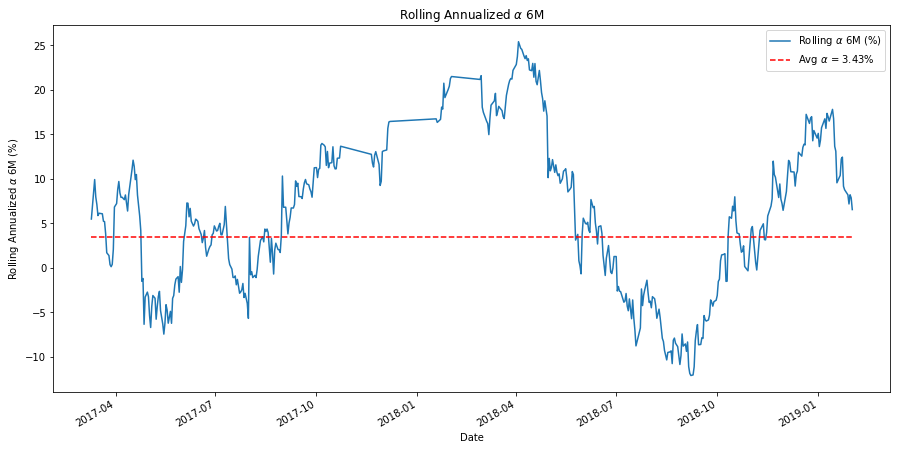

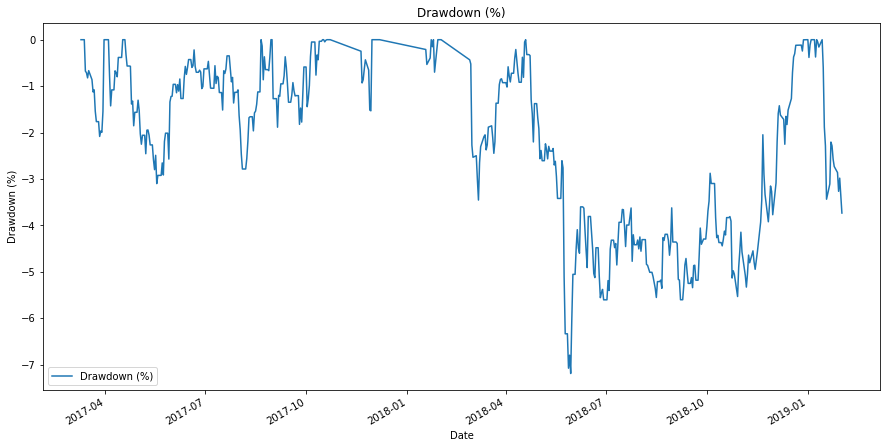

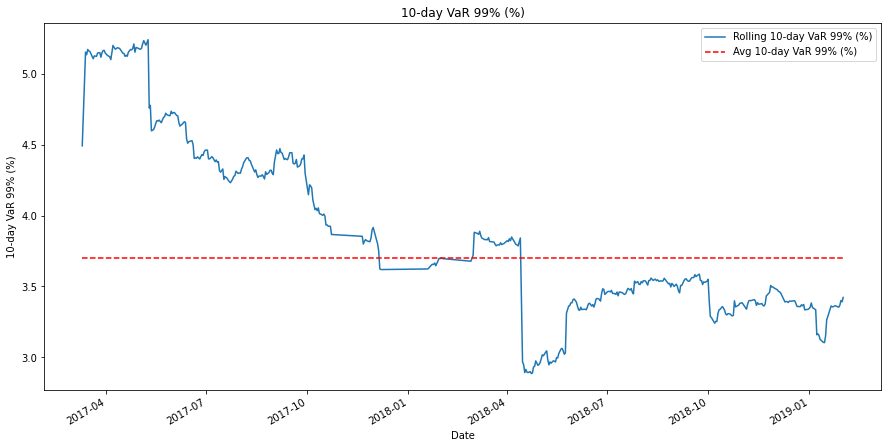

In [31]:
trade1 = trade_analysis_valid.query("bounds_id==3")['analyzer'].values[0]
trade1plots=trade1.plots()

In [32]:
ptback_test = PairTradingBacktest(test.Date, 
                             test['RY.TO'],
                             test['TD.TO'],
                             coint_coeffs=coint_params.tolist(),
                             mue = ou_parameters['mue'],
                             sigma_eq=ou_parameters['sigma'],
                             zscores=[0.4],
                             xy_label = ['RY.TO','TD.TO'],
                             tol=0.25)

In [33]:
ptback_test.backtest()

ptback_test.summary_tables()

,Strategy ID,Z-Score,# Trades,Annualized Return (%),Annualized Volatility (%),Cumulative Return (%),Avg # Days Open Position,Total Trading Days
0,1,0.4,4.0,3.021974,8.651638,2.330537,59.0,236


In [34]:
summary_test,trade_analysis_test = compute_risk_metrics(ptback_test.back_test_results,
                                                          historical_tbl=ptback_valid.back_test_results)

summary_test.applymap('{:.2f}'.format)


,Value (%)
Strategy,Z-Score = 0.4
Metric,
Annual Return,3.02
Annual Vol,8.65
Cumulative Return,2.33
Alpha (Annual),1.19
Sharpe,4.45
Beta,19.76
Beta P-Value,2.26
Alpha P-Value,90.34


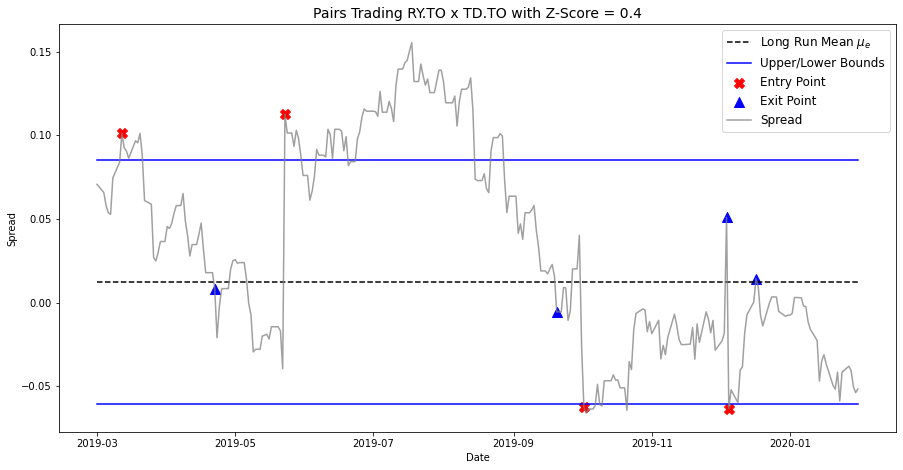

In [35]:
fig=ptback_test.plot_strategy(1)

### Pair 2: JPYUSD x Gold Futures

#### Engle Granger Fitting

In [36]:
eg = EngleGranger()
eg.fit(train['JPYUSD=X'],train['GC=F'])

In [37]:

eg.compare_ols

Variable   GC=F                         Variable JPYUSD=X          \
Statistic             Beta P-Value     SE  T-Stat               Beta P-Value   
0          Constant  0.364   0.000  0.021  17.227  Constant    0.212   0.000   
1          JPYUSD=X  1.067   0.000  0.018  58.791      GC=F    0.590   0.000   

                          
Statistic     SE  T-Stat  
0          0.016  13.102  
1          0.010  58.791

In [38]:
eg.compare_adf

,Equation 1:,GC=F = JPYUSD=X + Constant,,Equation 2:,JPYUSD=X = GC=F + Constant,
Null Hypothesis,Series has unit root,,,Series has unit root,,
T-Statistic,-3.296319,,,-2.852289,,
P-Value (MacKinnon),0.015044,,,0.051184,,
Optimal Lag,24,,,25,,
Confidence Level,1%,5%,10%,1%,5%,10%
Mackinnon Critical Value,-3.433567,-2.862961,-2.567527,-3.433567,-2.862961,-2.567527
Reject/Not Reject H0,Not Reject,Reject,Reject,Not Reject,Not Reject,Reject
Stationary/Non Stationary,Non Stationary,Stationary,Stationary,Non Stationary,Non Stationary,Stationary


In [39]:
eg.ecm_results_table

dY                       
Statistic       Beta P-Value     SE  T-Stat
Variable                                   
dX             0.175   0.002  0.055   3.157
Residual(-1)  -0.010   0.000  0.003  -3.989

In [40]:

eg.best_ols.table_params_out

GC=F                       
Statistic   Beta P-Value     SE  T-Stat
Variable                               
Constant   0.364   0.000  0.021  17.227
JPYUSD=X   1.067   0.000  0.018  58.791

In [41]:
eg.ou_process_summary

,Value
OU Process Parameters,
$\mu_e$,0.016859
Half-Life (days),74.867917
$\sigma$,0.376355
$\theta$,2.333083


In [42]:
coint_params= eg.cointegration_params

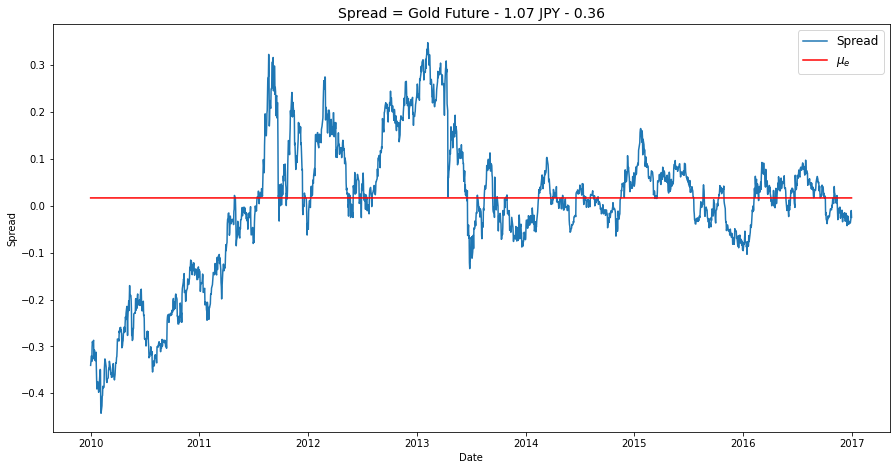

In [43]:
ou_parameters= eg.ou_process_params
coint_params= eg.cointegration_params
spread = eg.best_ols.residual.flatten()

fig= plt.figure(figsize=(15,7.5))
plt.plot(train.Date, spread,label='Spread')
plt.plot(train.Date, ou_parameters['mue']*np.ones(shape=train.Date.shape),color='red',label=r"$\mu_e$")
plt.title(f"Spread = Gold Future - {coint_params[1]:.2f} JPY - {coint_params[0]:.2f}",fontsize=14)
plt.xlabel("Date")
plt.ylabel("Spread")
plt.legend(loc='best',fontsize=12)
plt.show()



In [44]:
ptback_train = PairTradingBacktest(train.Date, 
                             train['JPYUSD=X'],
                             train['GC=F'],
                             coint_coeffs=coint_params.tolist(),
                             mue = ou_parameters['mue'],
                             sigma_eq=ou_parameters['sigma'],
                             zscores=z,
                             xy_label = ['JPYUSD','GC'],
                             tol=0.25)

ptback_valid = PairTradingBacktest(valid.Date, 
                             valid['JPYUSD=X'],
                             valid['GC=F'],
                             coint_coeffs=coint_params.tolist(),
                             mue = ou_parameters['mue'],
                             sigma_eq=ou_parameters['sigma'],
                             zscores=z,
                             xy_label = ['JPYUSD','GC'],
                             tol=0.25)

In [45]:
train_backtest=ptback_train.backtest()
valid_backtest=ptback_valid.backtest()



In [48]:
summary_train,trade_analysis_train = compute_risk_metrics(ptback_train.back_test_results,"XIU.TO")
summary_valid,trade_analysis_valid = compute_risk_metrics(ptback_valid.back_test_results,
                                                          "XIU.TO",
                                                          historical_tbl=ptback_train.back_test_results)

In [50]:
ptback_train.summary_tables()

,Strategy ID,Z-Score,# Trades,Annualized Return (%),Annualized Volatility (%),Cumulative Return (%),Avg # Days Open Position,Total Trading Days
0,1,0.2,20.0,17.119293,19.961850,114.636778,77.000000,1540
1,2,0.3,9.0,19.558349,20.893796,80.358593,117.777778,1060
2,3,0.4,7.0,21.072362,20.907375,76.936272,136.000000,952
3,4,0.5,5.0,19.355636,20.793530,59.731227,170.000000,850
4,5,0.6,4.0,19.135783,20.708165,53.846638,198.000000,792
5,6,0.7,3.0,23.841656,21.598017,50.020984,202.000000,606


In [51]:
summary_train

Value (%)                                            \
Strategy          Z-Score = 0.2 Z-Score = 0.3 Z-Score = 0.4 Z-Score = 0.5   
Metric                                                                      
Annual Return         17.119293     19.558349     21.072362     19.355636   
Annual Vol            19.961850     20.893796     20.907375     20.793530   
Cumulative Return    114.636778     80.358593     76.936272     59.731227   
Alpha (Annual)        17.803880     20.139353     21.145661     19.274399   
Sharpe                70.910225     77.882200     83.684626     76.746172   
Beta                   0.040365    -10.418381     -7.052125     -6.043313   
Beta P-Value          99.256608      5.407362     23.243603     32.782406   
Alpha P-Value          5.041780      8.011467      8.136040     13.304321   
Max Drawdown          20.115238     17.573266     16.459400     16.160612   
1-Day VaR 99%          2.854742      2.982405      2.979395      2.968485   
10-Day VaR 99%         8.544815      8.887597      8.843881      8.848865   
1-Day ES 99%           3.280859      3.428416      3.425695      3.412356   
10-Day ES 99%          9.892315     10.298008     10.255208     10.252507   

                                               
Strategy          Z-Score = 0.6 Z-Score = 0.7  
Metric                                         
Annual Return         19.135783     23.841656  
Annual Vol            20.708165     21.598017  
Cumulative Return     53.846638     50.020984  
Alpha (Annual)        19.847979     23.664414  
Sharpe                76.042282     91.116677  
Beta                   3.178233     18.842919  
Beta P-Value          63.302121      1.446259  
Alpha P-Value         13.427589     13.074335  
Max Drawdown          16.160612     13.416767  
1-Day VaR 99%          2.956778      3.071070  
10-Day VaR 99%         8.817331      9.068581  
1-Day ES 99%           3.398826      3.532113  
10-Day ES 99%         10.215210     10.526529

In [54]:
ptback_valid.summary_tables()

,Strategy ID,Z-Score,# Trades,Annualized Return (%),Annualized Volatility (%),Cumulative Return (%),Avg # Days Open Position,Total Trading Days
0,1,0.2,2.0,1.285198,10.414184,1.351944,166.0,332
1,2,0.3,1.0,5.737122,10.540438,5.713718,318.0,318


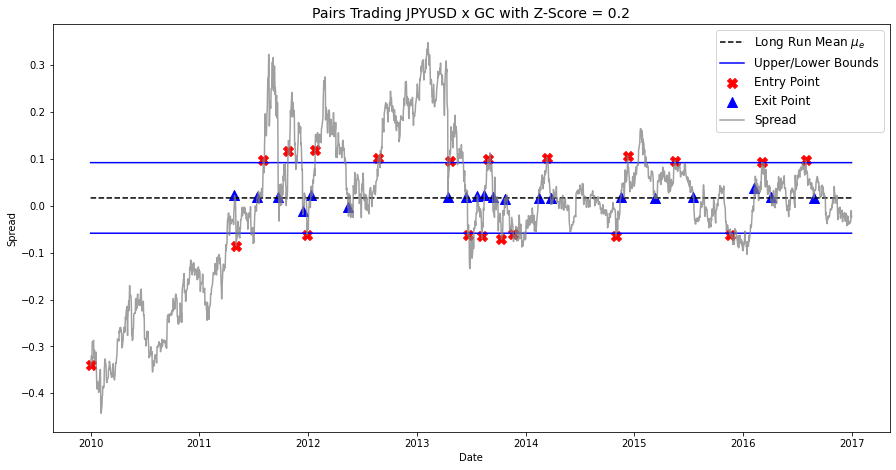

In [56]:
fig=ptback_train.plot_strategy(1)


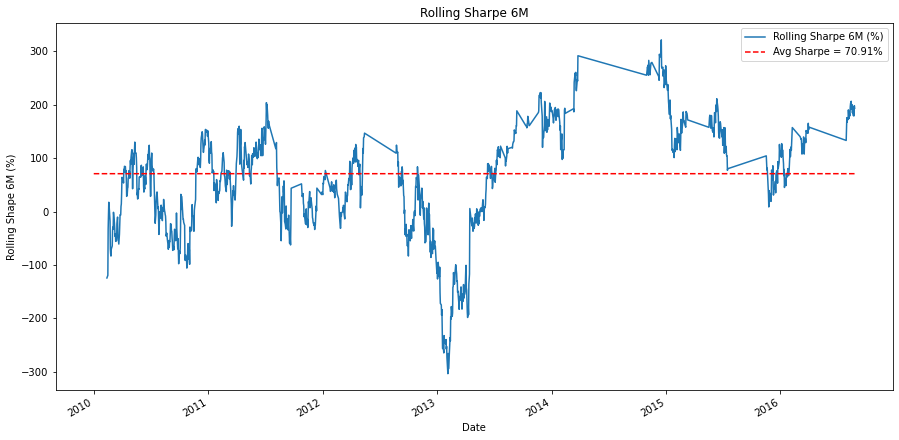

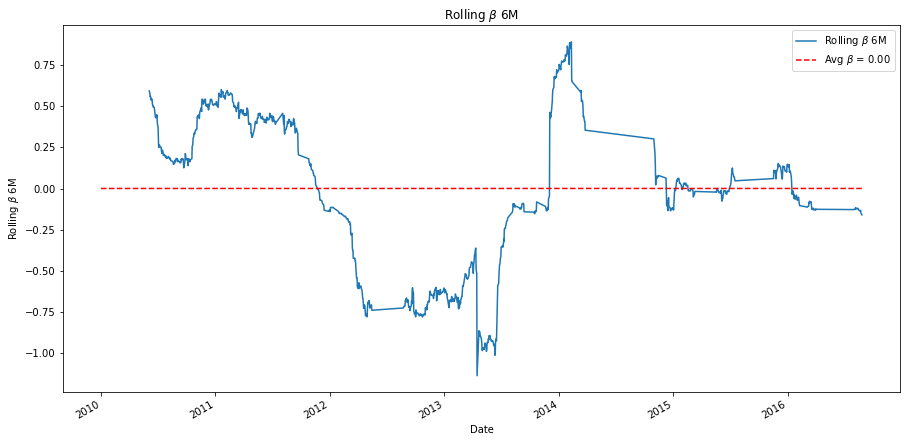

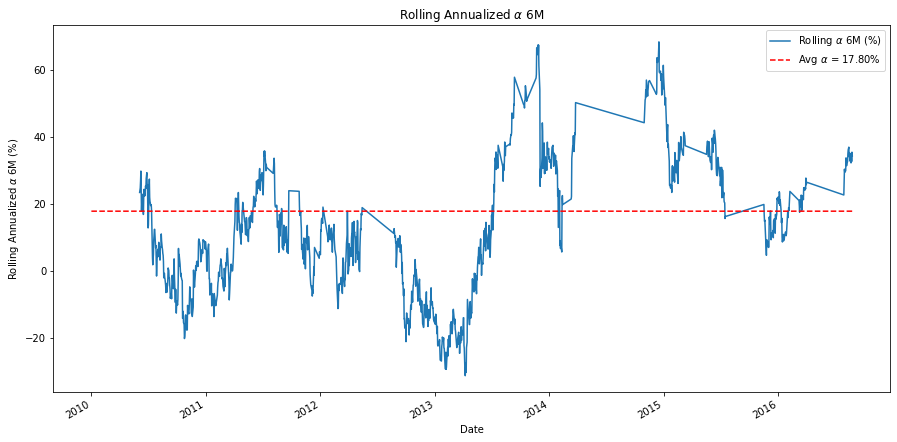

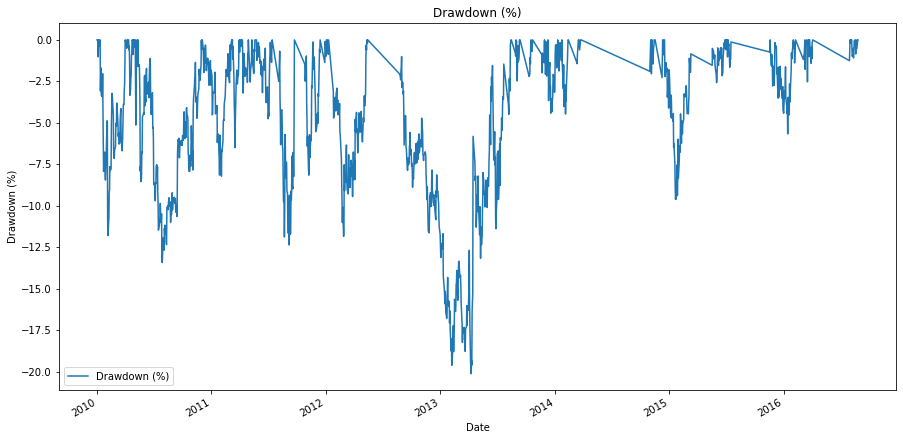

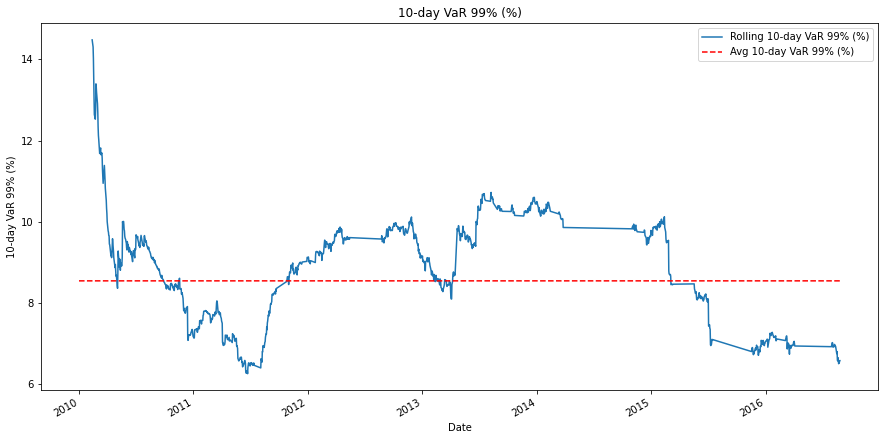

In [57]:
trainanalyzer=trade_analysis_train.query("bounds_id==1")['analyzer'][0]
figs=trainanalyzer.plots()


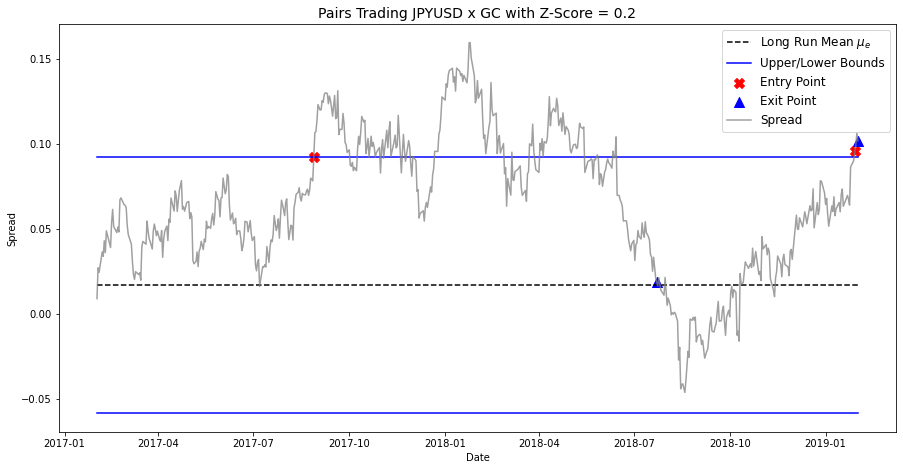

In [58]:
fig=ptback_valid.plot_strategy(1)


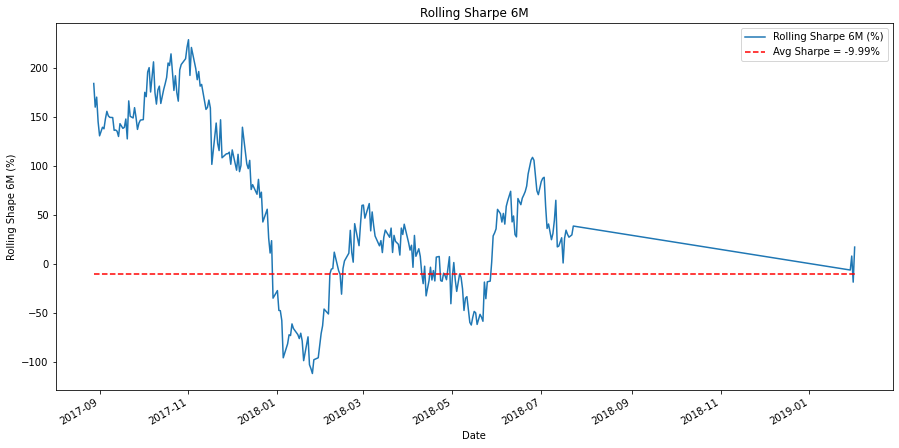

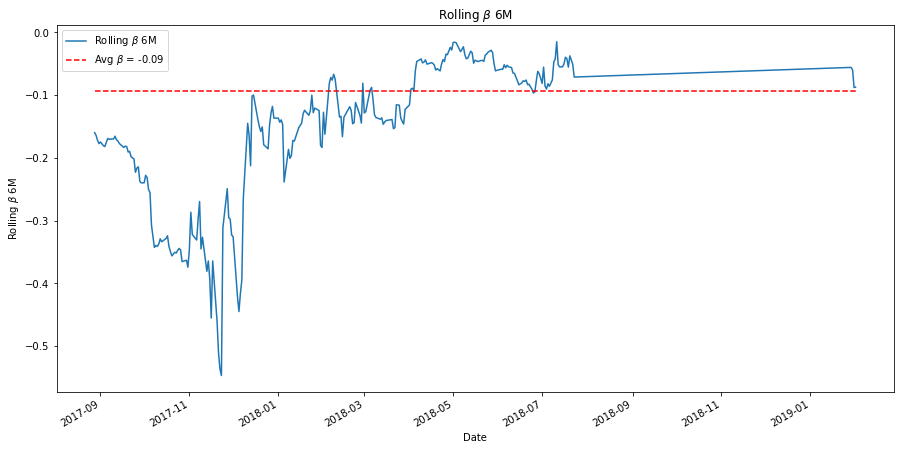

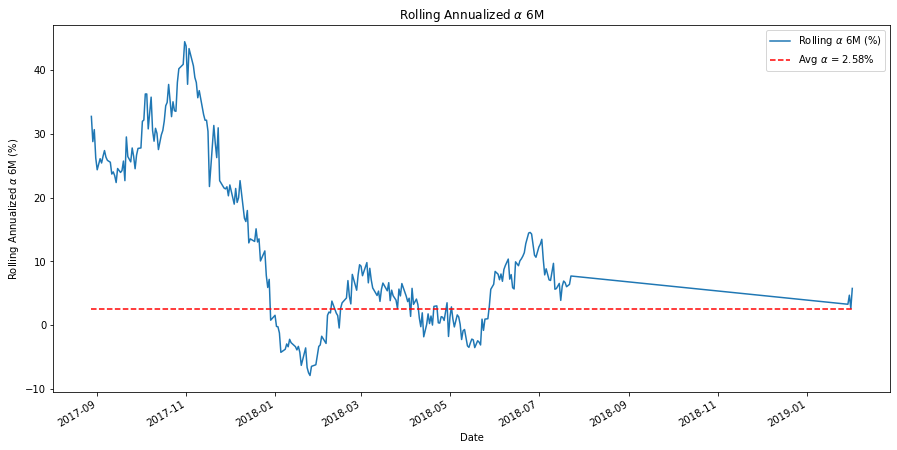

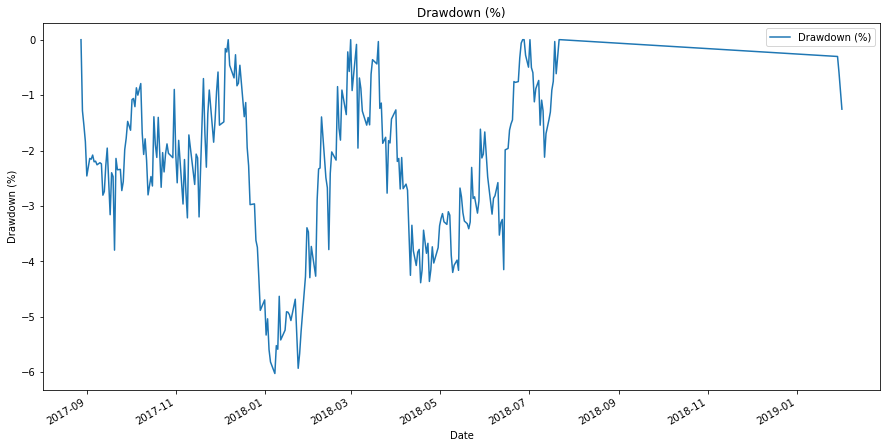

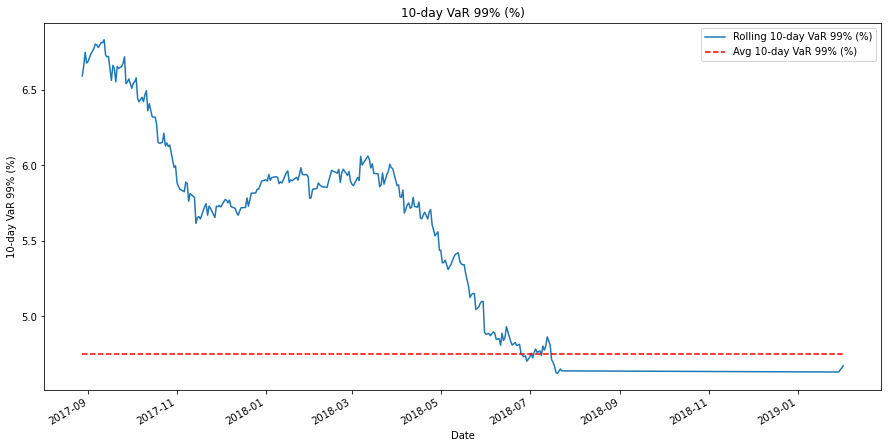

In [60]:
valanalyzer=trade_analysis_valid.query("bounds_id==1")['analyzer'][0]
figs=valanalyzer.plots()


### Pair 3: CAD x Oil Future

#### Engle Granger Fitting

In [61]:
eg = EngleGranger()
eg.fit(train['CADUSD=X'],train['BZ=F'])

In [62]:
eg.compare_ols

Variable    BZ=F                          Variable CADUSD=X  \
Statistic              Beta P-Value     SE   T-Stat               Beta   
0          Constant  -1.408   0.000  0.025  -55.691  Constant    0.626   
1          CADUSD=X   2.528   0.000  0.028   91.472      BZ=F    0.318   

                                   
Statistic P-Value     SE   T-Stat  
0           0.000  0.003  192.742  
1           0.000  0.003   91.472

In [63]:
eg.compare_adf

,Equation 1:,BZ=F = CADUSD=X + Constant,,Equation 2:,CADUSD=X = BZ=F + Constant,
Null Hypothesis,Series has unit root,,,Series has unit root,,
T-Statistic,-2.373115,,,-2.155834,,
P-Value (MacKinnon),0.149469,,,0.222664,,
Optimal Lag,2,,,2,,
Confidence Level,1%,5%,10%,1%,5%,10%
Mackinnon Critical Value,-3.433567,-2.862961,-2.567527,-3.433567,-2.862961,-2.567527
Reject/Not Reject H0,Not Reject,Not Reject,Not Reject,Not Reject,Not Reject,Not Reject
Stationary/Non Stationary,Non Stationary,Non Stationary,Non Stationary,Non Stationary,Non Stationary,Non Stationary
